In [1]:
# Packages 
using Pkg
using XLSX
using GLM
# using PyPlot
using PyCall
using Statistics
using DataFrames
using FreqTables
using Dates
using Plots
using StatsBase
using StatsPlots 
#using MLBase
using ScikitLearn
using Impute
using Missings
gr()
ENV["COLUMNS"], ENV["LINES"] = 200, 50
ENV["GKS_ENCODING"] = "utf-8";

## Podział na zbiory treningowy,  walidacyjny, testowy

In [2]:
df = DataFrame(XLSX.readtable("df.xlsx", "Sheet1")...); # wczytywanie danych 

In [ ]:
## Podział na zbiór treningowy, walidacyjny oraz testowy
df_train = filter(:date => <=(Date(2014,1, 1)), df[:,:])
df_validation = filter(:date => x -> x >(Date(2014,1,1)) && x <=(Date(2017,1, 1)) , df[:,:])
df_test = filter(:date => x -> x >(Date(2017,1, 1)) && x <=(Date(2020,12,1)), df[:,:]) # dane z 2021 nie wejda do analizy
size(df,1) == size(df_train,1) + size(df_test,1) + size(df_validation,1)

In [ ]:
XLSX.writetable("df_train.xlsx", collect(DataFrames.eachcol(df_train)), DataFrames.names(df_train))
XLSX.writetable("df_validation.xlsx", collect(DataFrames.eachcol(df_validation)), DataFrames.names(df_validation))
XLSX.writetable("df_test.xlsx", collect(DataFrames.eachcol(df_test)), DataFrames.names(df_test))  #zapis zbiorów

## Preporcessing

In [30]:
df_train = DataFrame(XLSX.readtable("df_train.xlsx", "Sheet1")...); # wczytywanie zbioru testowego

In [31]:
# zmiana porządku kolumn
select!(df_train, [:date,:company,:price, :mar_val, :tur_val, :cs_fl_sales, :ebit, :ebitda, :net_debt, :net_margin,
        :op_inc, :tot_assets, :tot_capital, :tot_debt, :tot_liab, :op_prof_margin,:vol_5y, :vol_1y,:pr_cs_flow, :p_b_val, :beta, 
         :debt_to_eq, :roe, :roi,:div_yield, :bidask_spread, :per, :asset_growth, :cap_exp_gr, 
        :num_shar_gr, :long_debt_gr, :mom_1M, :mom_3M, :mom_6M, :mom_12M,:mom_24M, :Target_1M,:Target_3M]) 
df_train[!,3:38 ] = passmissing(convert).(Float64, df_train[!, 3:38]); # ustalenie typu danych 

In [33]:
#### Zastępowanie missing values 

#medianą 
Impute.substitute!(df_train.vol_5y, statistic = median)
Impute.substitute!(df_train.per, statistic = median)
Impute.substitute!(df_train.p_b_val, statistic = median)
Impute.substitute!(df_train.beta, statistic = median)
Impute.substitute!(df_train.vol_1y, statistic = median)
Impute.substitute!(df_train.debt_to_eq, statistic = median)
Impute.substitute!(df_train.roe, statistic = median)
Impute.substitute!(df_train.roi, statistic = median)
Impute.substitute!(df_train.bidask_spread, statistic = median)

#zerami 
replace!(df_train.mom_1M, missing =>  0)
replace!(df_train.mom_3M, missing =>  0)
replace!(df_train.mom_6M, missing =>  0)
replace!(df_train.mom_24M, missing =>  0)
replace!(df_train.mom_12M, missing =>  0)

replace!(df_train.div_yield, missing =>  0)
replace!(df_train.asset_growth, missing =>  0)
replace!(df_train.long_debt_gr, missing =>  0)
replace!(df_train.cap_exp_gr, missing =>  0)
replace!(df_train.num_shar_gr, missing =>  0)

#pozostałe wskaźniki finansowe za pomocą KNN
df_train[:, 4:20] = Impute.knn(Matrix(df_train[:,4:20]); k = 1, threshold = 0.5); 

## Standaryzacja po dacie

In [35]:
@sk_import preprocessing: (LabelBinarizer, StandardScaler, RobustScaler, PowerTransformer)

map = DataFrameMapper([([:date,:company,:price], nothing),
([:mar_val, :tur_val], PowerTransformer(method="box-cox")),
([:cs_fl_sales, :ebit, :ebitda, :net_debt, :net_margin,:op_inc], StandardScaler()),
([:tot_assets], PowerTransformer(method="box-cox")),
([:tot_capital, :tot_debt, :tot_liab, :op_prof_margin,:vol_5y, :vol_1y,:pr_cs_flow, :p_b_val], StandardScaler()),
([:beta], nothing), 
([:debt_to_eq, :roe, :roi,:div_yield, :bidask_spread, :per, :asset_growth, :cap_exp_gr,:num_shar_gr, :long_debt_gr],StandardScaler()),
([:mom_1M, :mom_3M, :mom_6M, :mom_12M,:mom_24M, :Target_1M,:Target_3M], nothing)]);

In [36]:
function standardize(dataset)
    dates = unique(dataset.date)
    M = []
    for i in dates 
        if i == dates[1]
            crosssection = filter(:date => ==(i), copy(dataset[:,:]))
            transform = fit_transform!(map, crosssection)
            M = copy(transform)
        else
            crosssection = filter(:date => ==(i), copy(dataset[:,:]))
            transform = fit_transform!(map, crosssection)     
            M = vcat(M, transform)
        end
    end
    dataset[:,:] = M
end    

standardize(df_train);

## Preprocessing na zbiorze walidacyjnym

In [8]:
df_validation = DataFrame(XLSX.readtable("df_validation.xlsx", "Sheet1")...);

select!(df_validation, [:date,:company,:price, :mar_val, :tur_val, :cs_fl_sales, :ebit, :ebitda, :net_debt, :net_margin,
        :op_inc, :tot_assets, :tot_capital, :tot_debt, :tot_liab, :op_prof_margin,:vol_5y, :vol_1y,:pr_cs_flow, :p_b_val, :beta, 
         :debt_to_eq, :roe, :roi,:div_yield, :bidask_spread, :per, :asset_growth, :cap_exp_gr, 
        :num_shar_gr, :long_debt_gr, :mom_1M, :mom_3M, :mom_6M, :mom_12M,:mom_24M, :Target_1M,:Target_3M]) 
df_validation[!,3:38 ] = passmissing(convert).(Float64, df_validation[!, 3:38]);

#### Zastępowanie missing values 
Impute.substitute!(df_validation.vol_5y, statistic = median)
Impute.substitute!(df_validation.per, statistic = median)
Impute.substitute!(df_validation.p_b_val, statistic = median)
Impute.substitute!(df_validation.beta, statistic = median)
Impute.substitute!(df_validation.vol_1y, statistic = median)
Impute.substitute!(df_validation.debt_to_eq, statistic = median)
Impute.substitute!(df_validation.roe, statistic = median)
Impute.substitute!(df_validation.roi, statistic = median)

replace!(df_validation.mom_1M, missing =>  0)
replace!(df_validation.mom_3M, missing =>  0)
replace!(df_validation.mom_6M, missing =>  0)
replace!(df_validation.mom_24M, missing =>  0)
replace!(df_validation.mom_12M, missing =>  0)

replace!(df_validation.div_yield, missing =>  0)
replace!(df_validation.asset_growth, missing =>  0)
replace!(df_validation.long_debt_gr, missing =>  0)
replace!(df_validation.cap_exp_gr, missing =>  0)
replace!(df_validation.num_shar_gr, missing =>  0)

Impute.substitute!(df_validation.bidask_spread, statistic = median)

df_validation[:, 4:20] = Impute.knn(Matrix(df_validation[:,4:20]); k = 1, threshold = 0.5);  #pozostałe wskaźniki finansowe za pomocą KNN

standardize(df_validation);

## Modelowanie: Drzewo 

In [9]:
df_train_numerical = copy(df_train[:, (4:36)])
df_train_target = copy(df_train[:, (37:38)]);
df_validation_numerical = copy(df_validation[:, (4:36)])
df_validation_target = copy(df_validation[:, (37:38)]);

In [10]:
### Model 
@sk_import linear_model: LinearRegression
@sk_import tree: DecisionTreeRegressor
@sk_import tree: export_graphviz
@sk_import ensemble:  RandomForestRegressor
@sk_import metrics: explained_variance_score
@sk_import metrics: mean_squared_error
@sk_import metrics: mean_absolute_error
@sk_import metrics:  r2_score;

In [ ]:
Random.seed!(100)
model1 = DecisionTreeRegressor(random_state=100)
path = model1.cost_complexity_pruning_path(Array(df_train_numerical), Array(df_train_target.Target_1M))
ccp_alphas = get(path, "ccp_alphas",1)
impurities = get(path, "impurities",1);
Plots.plot(ccp_alphas, impurities, xlabel = "alpha", ylabel="Total impurity of leaves"); # alpha pomiedzy 0 a 1.5 

In [ ]:
ccp_alpha = collect(0:0.1:1.5); 
ccp_alpha = collect(0.7:0.01:1.1);

In [13]:
#ccp_alpha = collect(0:0.1:1.5); 
ccp_alpha = collect(0.55:0.01:1.0);
train_mse = []
validation_mse = []
train_r2 = []
validation_r2 = []

for a in ccp_alpha
    model = DecisionTreeRegressor(ccp_alpha = a, random_state=100)
    ScikitLearn.fit!(model, Array(df_train_numerical) , Array(df_train_target.Target_1M))
    MSE_t = mean_squared_error(model.predict(Array(df_train_numerical)), Array(df_train_target.Target_1M))
    MSE_v = mean_squared_error(model.predict(Array(df_validation_numerical)), Array(df_validation_target.Target_1M))
    r2_t = model.score(Array(df_train_numerical) , Array(df_train_target.Target_1M))
    r2_v = model.score(Array(df_validation_numerical) , Array(df_validation_target.Target_1M))
    push!(train_r2, r2_t)
    push!(validation_r2, r2_v)
    push!(train_mse, MSE_t)
    push!(validation_mse, MSE_v)
end

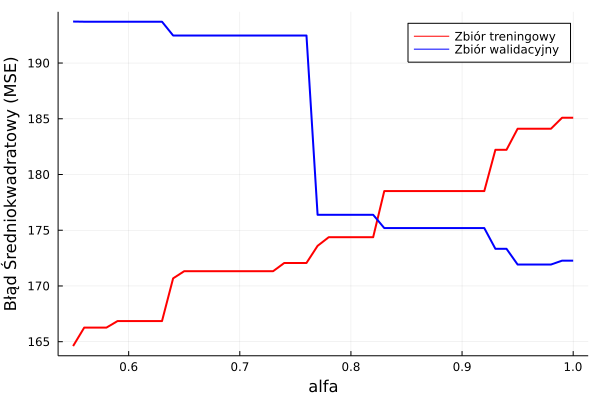

In [41]:
M = hcat(validation_mse,ccp_alpha)
m = M[argmin(M[:,1]),2]
Plots.plot(ccp_alpha, train_mse, xlabel = "alfa", ylabel =  "Błąd Średniokwadratowy (MSE)", label = "Zbiór treningowy", linewidth=2, c = "red")
Plots.plot!(ccp_alpha, validation_mse, linewidth=2, c = "blue" , label = "Zbiór walidacyjny")
#annotate!((0.72, 0.55), "Optymalna wartość alfa: $m", font(10, "Calibri Light"))

In [65]:
alpha = 0.8 # alpha 0.8 ma gorsze rezultaty, alfa 0.9 ma lepszy wynik niz zbior treningowy
modelDT = DecisionTreeRegressor(ccp_alpha = alpha, random_state=100)
ScikitLearn.fit!(modelDT , Array(df_train_numerical) , Array(df_train_target.Target_1M))
pred = modelDT.predict(Array(df_validation_numerical))
MSE = mean_squared_error(pred, Array(df_validation_target.Target_1M))
MAE = mean_absolute_error(pred, Array(df_validation_target.Target_1M))
STD_pred = round(Statistics.std(Array(pred)), digits = 2);
R2 = round(modelDT.score(Array(df_validation_numerical) , Array(df_validation_target.Target_1M)), digits = 2)
STD = round(Statistics.std(Array(df_validation_target.Target_1M)), digits = 2);
modelDT.get_params();

In [66]:
#@show MSE 
#@show MAE 

println("WYNIKI DRZEWA DECYZYJNEGO NA ZBIORZE WALIDACYJNYM")
println("Błąd Średniokwadratowy (MSE): ", round(MSE, digits = 2))
println("Średni bład absolutny (MAE): ", round(MAE, digits = 2))
println("Prognozowany średni zwrot: ", round(mean(pred), digits = 2))
println("Średni zwrot na zbiorze walidacyjnym: ", round(mean(df_validation_target.Target_1M), digits = 2))
println("Odchylenie standardowe prognozowanych zwrotów: ", STD_pred)
println("Odchylenie standardowe na zbiorze walidacyjnym: ", STD)
println("Współczynnik R2: ", R2)
println("Liczba liści: ", modelDT.get_n_leaves())
println("Głebokość drzewa: ", modelDT.get_depth())
hcat(names(df_validation_numerical), modelDT.feature_importances_)


WYNIKI DRZEWA DECYZYJNEGO NA ZBIORZE WALIDACYJNYM
Błąd Średniokwadratowy (MSE): 176.39
Średni bład absolutny (MAE): 7.97
Prognozowany średni zwrot: 1.8
Średni zwrot na zbiorze walidacyjnym: 1.16
Odchylenie standardowe prognozowanych zwrotów: 4.14
Odchylenie standardowe na zbiorze walidacyjnym: 12.89
Współczynnik R2: -0.06
Liczba liści: 25
Głebokość drzewa: 8


33×2 Matrix{Any}:
 "mar_val"         0.0275793
 "tur_val"         0.0
 "cs_fl_sales"     0.0
 "ebit"            0.0
 "ebitda"          0.0
 "net_debt"        0.0
 "net_margin"      0.0
 "op_inc"          0.0383647
 "tot_assets"      0.019004
 "tot_capital"     0.0949489
 "tot_debt"        0.0
 "tot_liab"        0.0417791
 "op_prof_margin"  0.0
 "vol_5y"          0.0
 "vol_1y"          0.0319748
 "pr_cs_flow"      0.0
 "p_b_val"         0.0
 "beta"            0.0
 "debt_to_eq"      0.0
 "roe"             0.0
 "roi"             0.0194645
 "div_yield"       0.0
 "bidask_spread"   0.039573
 "per"             0.0681981
 "asset_growth"    0.0
 "cap_exp_gr"      0.0409834
 "num_shar_gr"     0.105253
 "long_debt_gr"    0.18826
 "mom_1M"          0.0443265
 "mom_3M"          0.0
 "mom_6M"          0.181341
 "mom_12M"         0.0189731
 "mom_24M"         0.039977

## Modelowanie las

In [75]:
### Liczba drzew w lesie

forest = collect(10:10:250);
n_trees = 130
n_sample = 7 #18 wcześniej 
train_score = []
validation_score = []
train_r2 = []
validation_r2 = []

@time for n in forest
    model = RandomForestRegressor(n_estimators=n, max_samples = n_sample, random_state=100)
    ScikitLearn.fit!(model, Array(df_train_numerical) , Array(df_train_target.Target_1M))
    MSE_t = mean_squared_error(model.predict(Array(df_train_numerical)), Array(df_train_target.Target_1M))
    MSE_v = mean_squared_error(model.predict(Array(df_validation_numerical)), Array(df_validation_target.Target_1M))
    r2_t = model.score(Array(df_train_numerical) , Array(df_train_target.Target_1M))
    r2_v = model.score(Array(df_validation_numerical) , Array(df_validation_target.Target_1M))
    push!(train_r2, r2_t)
    push!(validation_r2, r2_v)
    push!(train_score, MSE_t)
    push!(validation_score, MSE_v)
end

### najpierw została ustalona odpowiednia liczba drzew, później za pomocą tego samego kodu optymalna liczba sampli

 16.148920 seconds (33.21 M allocations: 793.772 MiB, 11.46% gc time)


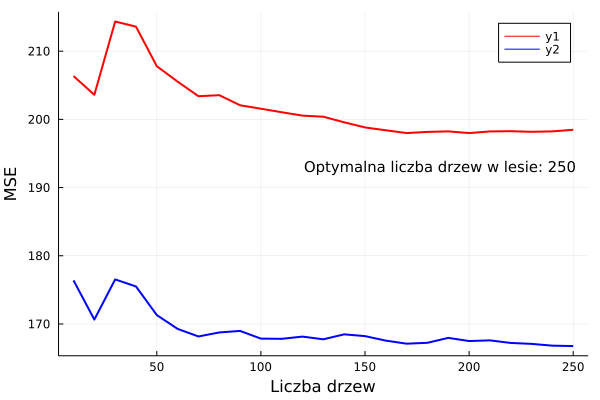

In [76]:
M = hcat(validation_score, forest)
m = M[argmin(M[:,1]),2]
Plots.plot(forest, train_score, xlabel = "Liczba drzew", ylabel =  "MSE", linewidth=2, c = "red")
Plots.plot!(forest, validation_score, linewidth=2, c = "blue" );
annotate!((0.72, 0.55), "Optymalna liczba drzew w lesie: $m", font(10, "Calibri Light"))

In [69]:
### hiperparametry: liczba zmiennych w jednym oszacowaniu

samples = collect(2:2:32)
n_trees = 260
n_sample = 18
train_score = []
validation_score = []
train_r2 = []
validation_r2 = []

@time for n in samples
    model = RandomForestRegressor(n_estimators=n_trees, max_samples = n, random_state=100)
    ScikitLearn.fit!(model, Array(df_train_numerical) , Array(df_train_target.Target_1M))
    MSE_t = mean_squared_error(model.predict(Array(df_train_numerical)), Array(df_train_target.Target_1M))
    MSE_v = mean_squared_error(model.predict(Array(df_validation_numerical)), Array(df_validation_target.Target_1M))
    r2_t = model.score(Array(df_train_numerical) , Array(df_train_target.Target_1M))
    r2_v = model.score(Array(df_validation_numerical) , Array(df_validation_target.Target_1M))
    push!(train_r2, r2_t)
    push!(validation_r2, r2_v)
    push!(train_score, MSE_t)
    push!(validation_score, MSE_v)
end

 15.305362 seconds (21.26 M allocations: 508.014 MiB, 6.58% gc time)


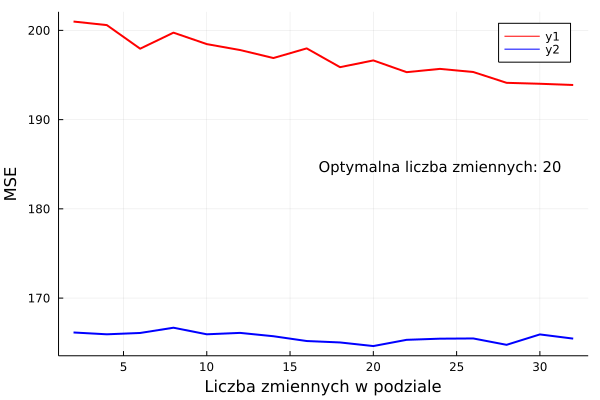

In [70]:
M = hcat(validation_score, samples)
m = M[argmin(M[:,1]),2]
Plots.plot(samples, train_score, xlabel = "Liczba zmiennych w podziale", ylabel =  "MSE", linewidth=2, c = "red")
Plots.plot!(samples, validation_score, linewidth=2, c = "blue" )
annotate!((0.72, 0.55), "Optymalna liczba zmiennych: $m", font(10, "Calibri Light"))


In [ ]:
### hiperparametry:alpha - nie ma roznicy w oszacowaniach

alphas = collect(0:0.1:1)
n_trees = 260
n_sample = 14
train_score = []
validation_score = []
train_r2 = []
validation_r2 = []

@time for a in alphas
    model = RandomForestRegressor(n_estimators=n_trees, max_samples = n_sample, ccp_alpha = a, random_state=100)
    ScikitLearn.fit!(model, Array(df_train_numerical) , Array(df_train_target.Target_1M))
    MSE_t = mean_squared_error(model.predict(Array(df_train_numerical)), Array(df_train_target.Target_1M))
    MSE_v = mean_squared_error(model.predict(Array(df_validation_numerical)), Array(df_validation_target.Target_1M))
    r2_t = model.score(Array(df_train_numerical) , Array(df_train_target.Target_1M))
    r2_v = model.score(Array(df_validation_numerical) , Array(df_validation_target.Target_1M))
    push!(train_r2, r2_t)
    push!(validation_r2, r2_v)
    push!(train_score, MSE_t)
    push!(validation_score, MSE_v)
end

In [ ]:
M = hcat(validation_score, alphas)
m = M[argmin(M[:,1]),2]
Plots.plot(alphas, train_score, xlabel = "Parametr alfa", ylabel =  "MSE", linewidth=2, c = "red")
Plots.plot!(alphas, validation_score, linewidth=2, c = "blue" )
annotate!((0.72, 0.55), "Optymalna wartość alpha: $m", font(10, "Calibri Light"))

In [77]:
### Oszacowanie głównego modelu lasów losowych 
n_trees = 260
n_sample = 20 # tutaj wczesniej bylo 16
alpha = 0.7
RF_model = RandomForestRegressor(n_estimators=n_trees, max_samples = n_sample, ccp_alpha = alpha, random_state=100)
ScikitLearn.fit!(RF_model, Array(df_train_numerical) , Array(df_train_target.Target_1M))
pred = RF_model.predict(Array(df_validation_numerical))
MSE = mean_squared_error(pred, Array(df_validation_target.Target_1M))
MAE = mean_absolute_error(pred, Array(df_validation_target.Target_1M))
STD = round(Statistics.std(Array(df_validation_target.Target_1M)), digits = 2);

In [78]:
@show MSE 
@show MAE 
println("Prognozowany średni zwrot: ", round(mean(pred), digits = 2))
println("Średni zwrot na zbiorze walidacyjnym: ", round(mean(df_validation_target.Target_1M), digits = 2))
println("Oschylenie standardowe na zbiorze walidacyjnym: ", STD)
hcat(names(df_validation_numerical), RF_model.feature_importances_)

MSE = 164.5836194809086
MAE = 7.778983636522965
Prognozowany średni zwrot: 1.19
Średni zwrot na zbiorze walidacyjnym: 1.16
Oschylenie standardowe na zbiorze walidacyjnym: 12.89


33×2 Matrix{Any}:
 "mar_val"         0.0310041
 "tur_val"         0.0361363
 "cs_fl_sales"     0.0292473
 "ebit"            0.0152891
 "ebitda"          0.0147394
 "net_debt"        0.0160515
 "net_margin"      0.022081
 "op_inc"          0.0180225
 "tot_assets"      0.0236971
 "tot_capital"     0.0110178
 "tot_debt"        0.0127936
 "tot_liab"        0.0252484
 "op_prof_margin"  0.0297756
 "vol_5y"          0.0330574
 "vol_1y"          0.0426453
 "pr_cs_flow"      0.0460485
 "p_b_val"         0.0291546
 "beta"            0.0240982
 "debt_to_eq"      0.0246282
 "roe"             0.0189565
 "roi"             0.0441995
 "div_yield"       0.0226257
 "bidask_spread"   0.0244905
 "per"             0.0247318
 "asset_growth"    0.0408071
 "cap_exp_gr"      0.0316548
 "num_shar_gr"     0.0401015
 "long_debt_gr"    0.04129
 "mom_1M"          0.045879
 "mom_3M"          0.0400303
 "mom_6M"          0.0640477
 "mom_12M"         0.0387873
 "mom_24M"         0.0376624

## Zbiór testowy 

In [79]:
### Preprocessing na zbiorze testowym

df_test = DataFrame(XLSX.readtable("df_test.xlsx", "Sheet1")...);

select!(df_test, [:date,:company,:price, :mar_val, :tur_val, :cs_fl_sales, :ebit, :ebitda, :net_debt, :net_margin,
        :op_inc, :tot_assets, :tot_capital, :tot_debt, :tot_liab, :op_prof_margin,:vol_5y, :vol_1y,:pr_cs_flow, :p_b_val, :beta, 
         :debt_to_eq, :roe, :roi,:div_yield, :bidask_spread, :per, :asset_growth, :cap_exp_gr, 
        :num_shar_gr, :long_debt_gr, :mom_1M, :mom_3M, :mom_6M, :mom_12M,:mom_24M, :Target_1M,:Target_3M]) 
df_test[!,3:38 ] = passmissing(convert).(Float64, df_test[!, 3:38]);

#### Zastępowanie missing values 
Impute.substitute!(df_test.vol_5y, statistic = median)
Impute.substitute!(df_test.per, statistic = median)
Impute.substitute!(df_test.p_b_val, statistic = median)
Impute.substitute!(df_test.beta, statistic = median)
Impute.substitute!(df_test.vol_1y, statistic = median)
Impute.substitute!(df_test.debt_to_eq, statistic = median)
Impute.substitute!(df_test.roe, statistic = median)
Impute.substitute!(df_test.roi, statistic = median)

replace!(df_test.mom_1M, missing =>  0)
replace!(df_test.mom_3M, missing =>  0)
replace!(df_test.mom_6M, missing =>  0)
replace!(df_test.mom_24M, missing =>  0)
replace!(df_test.mom_12M, missing =>  0)

replace!(df_test.div_yield, missing =>  0)
replace!(df_test.asset_growth, missing =>  0)
replace!(df_test.long_debt_gr, missing =>  0)
replace!(df_test.cap_exp_gr, missing =>  0)
replace!(df_test.num_shar_gr, missing =>  0)

Impute.substitute!(df_test.bidask_spread, statistic = median)

df_test[:, 4:20] = Impute.knn(Matrix(df_test[:,4:20]); k = 1, threshold = 0.5);  #pozostałe wskaźniki finansowe za pomocą KNN

standardize(df_test);


In [80]:
df_test_numerical = copy(df_test[:, (4:36)])
df_test_target = copy(df_test[:, (37:38)]);

In [89]:
DT_model =  modelDT
DT_pred = modelDT.predict(Array(df_test_numerical))
DT_R2 = round(modelDT.score(Array(df_test_numerical) , Array(df_test_target.Target_1M)), digits = 2)
DT_MSE = round(mean_squared_error(DT_pred, Array(df_test_target.Target_1M)), digits = 2)
DT_MAE = round(mean_absolute_error(DT_pred, Array(df_test_target.Target_1M)), digits = 2)
DT_STD = round(Statistics.std(Array(DT_pred)), digits = 2);

In [90]:
RF_pred = RF_model.predict(Array(df_test_numerical))
RF_R2 = round(RF_model.score(Array(df_test_numerical) , Array(df_test_target.Target_1M)), digits = 2)
RF_MSE = round(mean_squared_error(RF_pred, Array(df_test_target.Target_1M)), digits = 2)
RF_MAE = round(mean_absolute_error(RF_pred, Array(df_test_target.Target_1M)), digits = 2)
RF_STD = round(Statistics.std(Array(RF_pred)), digits = 2);

In [91]:
RF_TEST = round(Statistics.std(Array(df_test_target.Target_1M)), digits = 2);

In [94]:
println("Drzewo decyzyjne")
@show DT_MSE
@show DT_MAE 
@show DT_R2
@show DT_STD
println("Prognozowany średni zwrot: ", round(mean(DT_pred), digits = 2))
println()
println("Lasy losowe")
@show RF_MSE
@show RF_MAE 
@show RF_R2
@show RF_STD
println("Prognozowany średni zwrot: ", round(mean(RF_pred), digits = 2))
println()
println()
println("Zbiór testowy")
println("Rzeczywisty średni zwrot na zbiorze testowym: ", round(mean(df_test_target.Target_1M), digits = 2))
println("Rzeczywiste odchylenie standardowe na zbiorze testowym: ", RF_TEST)

Drzewo decyzyjne
DT_MSE = 288.73
DT_MAE = 9.64
DT_R2 = -0.05
DT_STD = 4.48
Prognozowany średni zwrot: 1.01

Lasy losowe
RF_MSE = 270.8
RF_MAE = 9.3
RF_R2 = 0.01
RF_STD = 1.34
Prognozowany średni zwrot: 1.04


Zbiór testowy
Rzeczywisty średni zwrot na zbiorze testowym: 1.13
Rzeczywiste odchylenie standardowe na zbiorze testowym: 16.55


In [189]:
println("Drzewo decyzyjne")
DT_FI = DataFrame(hcat(names(df_test_numerical), DT_model.feature_importances_))
sort!(DT_FI, :x2, rev = true);

println("las losowy")
RF_FI =  DataFrame(hcat(names(df_test_numerical), RF_model.feature_importances_))
sort!(RF_FI, :x2, rev = true);

XLSX.writetable("DT_FI.xlsx", collect(DataFrames.eachcol(DT_FI)), DataFrames.names(DT_FI))
XLSX.writetable("RF_FI.xlsx", collect(DataFrames.eachcol(RF_FI)), DataFrames.names(RF_FI));

Drzewo decyzyjne
las losowy


## Strategia inwestycyjna 

In [191]:
df_test = hcat(df_test, DT_pred)
rename!(df_test, :x1 => :DT_pred)
df_test = hcat(df_test, RF_pred)
rename!(df_test, :x1 => :RF_pred);

In [674]:
#dataset = copy(df_test[:,[1,2,37,39,40]]);

In [192]:
function evaluation(dataset, predictor)
    dates = unique(dataset.date)
    D = []
    S = []
    K = []
    R = []
    A = []
    for i in dates
        crosssection = filter(:date => ==(i), copy(dataset[:,:]))
        sort!(crosssection, predictor, rev = true)
        top = Int(round(0.1*size(crosssection, 1) , digits = 0))
        t_std = round(Statistics.std(Array(crosssection[1:top, :].Target_1M)), digits = 2)
        t_mean = round(mean(Array(crosssection[1:top, :].Target_1M)), digits = 2)
        pred_std = round(Statistics.std(Array(crosssection[1:top, predictor])), digits = 2)
        pred_mean = round(mean(Array(crosssection[1:top, predictor])), digits = 2)
        push!(D, i)
        push!(S, t_std)
        push!(K, t_mean)
        push!(R, pred_std )
        push!(A, pred_mean)
    end
    M = DataFrame(:date => D,
        :target_std => S,
        :target_mean => K,
        :pred_std => R,
        :pred_mean => A)
end

evaluation (generic function with 1 method)

In [193]:
DT_eval = evaluation(df_test,  "DT_pred");
RF_eval = evaluation(df_test,  "RF_pred");

In [253]:
DT_describe = describe(DT_eval)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Int64,DataType
1,date,,2017-02-01,,2020-12-01,47,0,Any
2,target_std,14.7872,5.6,10.81,119.99,47,0,Any
3,target_mean,3.99532,-17.47,2.04,61.11,47,0,Any
4,pred_std,7.18255,0.0,3.55,33.0,28,0,Any
5,pred_mean,5.38085,2.28,4.17,16.77,30,0,Any


In [254]:
RF_describe = describe(RF_eval)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Int64,DataType
1,date,,2017-02-01,,2020-12-01,47,0,Any
2,target_std,21.2432,7.44,14.09,129.4,47,0,Any
3,target_mean,6.29532,-11.17,1.75,90.53,46,0,Any
4,pred_std,0.926809,0.61,0.91,1.37,31,0,Any
5,pred_mean,3.89468,3.08,3.88,5.12,40,0,Any


In [255]:
### zapisywanie tabel 

deletecols!(DT_describe, [6,7,8])
delete!(DT_describe, 1)
DT_describe[!, 2:4] = convert.(Float64, DT_describe[!, 2:4])
DT_describe[!, 1] = String.(DT_describe[:,1])

deletecols!(RF_describe, [6,7,8])
delete!(RF_describe, 1)
RF_describe[!, 2:4] = convert.(Float64, RF_describe[!, 2:4])
RF_describe[!, 1] = String.(RF_describe[:,1])

XLSX.writetable("DT_describe.xlsx", collect(DataFrames.eachcol(DT_describe)), DataFrames.names(DT_describe))
XLSX.writetable("RF_describe.xlsx", collect(DataFrames.eachcol(RF_describe)), DataFrames.names(RF_describe))

In [197]:
function annual_return(database)
    investment = 1
    for i in collect(1:1:12)
        investment = investment*(1+database[i,"target_mean"]/100)
    end
    ret = round((investment-1)*100, digits = 2)
    return ret
end

annual_return (generic function with 1 method)

In [198]:
function return_rate(database)
    investment = 1
    for i in collect(1:1:size(database,1))
        investment = investment*(1+database[i,"target_mean"]/100)
    end
    ret = round((investment-1)*100, digits = 2)
    return ret
end

return_rate (generic function with 1 method)

In [ ]:
function sharpe(r, r_f, std)
    sh = (r - r_f)/std
    return sh
end

In [259]:
Opis = ["Okres 1 - 12", "Okres 13 - 24", "Okres 24 - 36", "Okres 37 - 47", "Okres 1-36", "Okres 1-47 "]
DT_zwrot = []
DT_std = []
RF_zwrot = []
RF_std = []
risk_free = [1.88, 2.5, 1.57, 0.12, 1.98, 1.51]
DT_sharpe = []
RF_sharpe = []

Any[]

In [ ]:
push!(DT_zwrot, return_rate(DT_eval[1:12,:]))
push!(DT_zwrot,return_rate(DT_eval[13:24,:]))
push!(DT_zwrot,return_rate(DT_eval[25:36,:]))
push!(DT_zwrot,return_rate(DT_eval[37:47,:]))
push!(DT_zwrot,return_rate(DT_eval[1:36,:]))
push!(DT_zwrot,return_rate(DT_eval[1:47,:]));

In [ ]:
push!(DT_std, round(Statistics.std(Array(DT_eval[1:12,:target_mean])), digits = 2))
push!(DT_std, round(Statistics.std(Array(DT_eval[13:24,:target_mean])), digits = 2))
push!(DT_std, round(Statistics.std(Array(DT_eval[25:36,:target_mean])), digits = 2))
push!(DT_std, round(Statistics.std(Array(DT_eval[37:47,:target_mean])), digits = 2))
push!(DT_std, round(Statistics.std(Array(DT_eval[1:36,:target_mean])), digits = 2))
push!(DT_std, round(Statistics.std(Array(DT_eval[1:47,:target_mean])), digits = 2));

In [ ]:
push!(RF_zwrot, return_rate(RF_eval[1:12,:]))
push!(RF_zwrot,return_rate(RF_eval[13:24,:]))
push!(RF_zwrot,return_rate(RF_eval[25:36,:]))
push!(RF_zwrot,return_rate(RF_eval[37:47,:]))
push!(RF_zwrot,return_rate(RF_eval[1:36,:]))
push!(RF_zwrot,return_rate(RF_eval[1:47,:]));

In [ ]:
push!(RF_std, round(Statistics.std(Array(RF_eval[1:12,:target_mean])), digits = 2))
push!(RF_std, round(Statistics.std(Array(RF_eval[13:24,:target_mean])), digits = 2))
push!(RF_std, round(Statistics.std(Array(RF_eval[25:36,:target_mean])), digits = 2))
push!(RF_std, round(Statistics.std(Array(RF_eval[37:47,:target_mean])), digits = 2))
push!(RF_std, round(Statistics.std(Array(RF_eval[1:36,:target_mean])), digits = 2))
push!(RF_std, round(Statistics.std(Array(RF_eval[1:47,:target_mean])), digits = 2));

In [283]:
for i in 1:1:length(RF_zwrot)
    out = sharpe(RF_zwrot[i], risk_free[i], RF_std[i])
    push!(RF_sharpe, out)
end
RF_sharpe

6-element Vector{Any}:
  6.005934718100891
  3.3239202657807314
  9.578814627994957
 11.638738127544098
 26.777414075286416
 67.31414267834793

In [278]:
for i in 1:1:length(DT_zwrot)
    out = sharpe(DT_zwrot[i], risk_free[i], DT_std[i])
    push!(DT_sharpe, out)
end
DT_sharpe

6-element Vector{Any}:
  5.560493827160494
  2.5085714285714285
  7.745501285347043
  6.258091286307053
 20.214780600461893
 29.99599037690457

In [288]:
inwestycja = DataFrame(hcat(Opis, DT_zwrot, DT_std, DT_sharpe, RF_zwrot, RF_std, RF_sharpe, risk_free), 
    ["Opis", "DT_zwrot", "DT_std", "DT_sharpe", "RF_zwrot", "RF_std", "RF_sharpe", "risk_free"])

,Opis,DT_zwrot,DT_std,DT_sharpe,RF_zwrot,RF_std,RF_sharpe,risk_free
,Any,Any,Any,Any,Any,Any,Any,Any
1,Okres 1 - 12,24.4,4.05,5.56049,22.12,3.37,6.00593,1.88
2,Okres 13 - 24,15.67,5.25,2.50857,22.51,6.02,3.32392,2.5
3,Okres 24 - 36,31.7,3.89,7.7455,77.53,7.93,9.57881,1.57
4,Okres 37 - 47,150.94,24.1,6.25809,343.23,29.48,11.6387,0.12
5,Okres 1-36,89.51,4.33,20.2148,165.59,6.11,26.7774,1.98
6,Okres 1-47,375.56,12.47,29.996,1077.19,15.98,67.3141,1.51


In [289]:
XLSX.writetable("Inw_describe.xlsx", collect(DataFrames.eachcol(inwestycja)), DataFrames.names(inwestycja))